In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import lars_optimizer as lars
import pandas as pd

## Function to preprocess images for finetuning
same as in Finetune/data_util_fine.py

In [2]:
def random_apply(func, p, x):
  """Randomly apply function func to x with probability p."""
  return tf.cond(
      tf.less(
          tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
          tf.cast(p, tf.float32)), lambda: func(x), lambda: x)

def distorted_bounding_box_crop(image,
                                bbox,
                                min_object_covered=0.1,
                                aspect_ratio_range=(0.75, 1.33),
                                area_range=(0.05, 1.0),
                                max_attempts=100,
                                scope=None):
  """Generates cropped_image using one of the bboxes randomly distorted.

  See `tf.image.sample_distorted_bounding_box` for more documentation.

  Args:
    image: `Tensor` of image data.
    bbox: `Tensor` of bounding boxes arranged `[1, num_boxes, coords]`
        where each coordinate is [0, 1) and the coordinates are arranged
        as `[ymin, xmin, ymax, xmax]`. If num_boxes is 0 then use the whole
        image.
    min_object_covered: An optional `float`. Defaults to `0.1`. The cropped
        area of the image must contain at least this fraction of any bounding
        box supplied.
    aspect_ratio_range: An optional list of `float`s. The cropped area of the
        image must have an aspect ratio = width / height within this range.
    area_range: An optional list of `float`s. The cropped area of the image
        must contain a fraction of the supplied image within in this range.
    max_attempts: An optional `int`. Number of attempts at generating a cropped
        region of the image of the specified constraints. After `max_attempts`
        failures, return the entire image.
    scope: Optional `str` for name scope.
  Returns:
    (cropped image `Tensor`, distorted bbox `Tensor`).
  """
  with tf.name_scope(scope or 'distorted_bounding_box_crop'):
    shape = tf.shape(image)
    sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
        shape,
        bounding_boxes=bbox,
        min_object_covered=min_object_covered,
        aspect_ratio_range=aspect_ratio_range,
        area_range=area_range,
        max_attempts=max_attempts,
        use_image_if_no_bounding_boxes=True)
    bbox_begin, bbox_size, _ = sample_distorted_bounding_box

    # Crop the image to the specified bounding box.
    offset_y, offset_x, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, target_height, target_width)

    return image

def crop_and_resize(image, height, width):
  """Make a random crop and resize it to height `height` and width `width`.

  Args:
    image: Tensor representing the image.
    height: Desired image height.
    width: Desired image width.

  Returns:
    A `height` x `width` x channels Tensor holding a random crop of `image`.
  """
  bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
  aspect_ratio = width / height
  image = distorted_bounding_box_crop(
      image,
      bbox,
      min_object_covered=0.1,
      aspect_ratio_range=(3. / 4 * aspect_ratio, 4. / 3. * aspect_ratio),
      area_range=(0.08, 1.0),
      max_attempts=100,
      scope=None)
  return tf.image.resize([image], [height, width],
                         method=tf.image.ResizeMethod.BICUBIC)[0]

def random_crop_with_resize(image, height, width, p=1.0):
  """Randomly crop and resize an image.

  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    p: Probability of applying this transformation.

  Returns:
    A preprocessed image `Tensor`.
  """
  def _transform(image):  # pylint: disable=missing-docstring
    image = crop_and_resize(image, height, width)
    return image
  return random_apply(_transform, p=p, x=image)

def preprocess_for_train(image,
                         height,
                         width):
  """Preprocesses the given image for training.

  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
  Returns:
    A preprocessed image `Tensor`.
  """
  image = random_crop_with_resize(image, height, width)
  image = tf.image.random_flip_left_right(image)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image

def preprocess_image(image, height, width):
  """Preprocesses the given image.

  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
  Returns:
    A preprocessed image `Tensor` of range [0, 1].
  """
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)

  return preprocess_for_train(image, height, width)

In [3]:
dataset = 'cats_vs_dogs'
batch_size = 512
#only first 10% of dogs-cats images for finetuning
tfds_dogs_10pct_ds, info = tfds.load(dataset, split='train[:10%]', with_info=True)
num_images = info.splits['train[:10%]'].num_examples
num_classes = info.features['label'].num_classes
print('There are {} images in 10% dogs_vs_cats dataset. Obviously are {} classes'.format(num_images,num_classes))

There are 2326 images in 10% dogs_vs_cats dataset. Obviously are 2 classes


In [4]:
def _preprocess(x):
    x['image'] = preprocess_image(x['image'], 100, 100)
    return x
ds_10pct = tfds_dogs_10pct_ds.map(_preprocess).batch(batch_size)

Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


## Create/Load Model

In [5]:
learning_rate = 0.1

class Model(tf.keras.Model):
    def __init__(self, path):
        super(Model, self).__init__()
        self.saved_model = tf.saved_model.load(path)
        self.dense_layer = tf.keras.layers.Dense(units=num_classes, name='head_supervised_new')
        self.optimizer = lars.LARSOptimizer(learning_rate, momentum=0.9, weight_decay=0.,
                        exclude_from_weight_decay=['batch_normalization', 'bias', 'head_supervised'])
        
    def call(self, x):
        with tf.GradientTape() as tape:
            outputs = self.saved_model(x['image'], trainable=False)
            print(10*'#' + 'outputs' + 10*'#')
            print(outputs)
            print(26*'#')
            logits_t = self.dense_layer(outputs['final_avg_pool'])
            loss_t = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                    labels = tf.one_hot(x['label'], num_classes), logits=logits_t))
            dense_layer_weights = self.dense_layer.trainable_weights
            print(10*'#' + 'Trainable variables' + 10*'#')
            print(dense_layer_weights)
            print(26*'#')
            grads = tape.gradient(loss_t, dense_layer_weights)
            self.optimizer.apply_gradients(zip(grads, dense_layer_weights))
            return loss_t, x['image'], logits_t, x['label']

In [6]:
#path to model
model_path = 'resnet50_pretrain100epochs_ImageNet/saved_model/'
#get_model 
model = Model(model_path)

In [7]:
##function to train a step
@tf.function
def train_step(x):
    return model(x)

In [8]:
counter_foo = 0
hist_loss, hist_acc, steps = [], [], []
for epoch in range(50):
    for x in ds_10pct:
        counter_foo += 1
        loss, image, logits, labels = train_step(x)
        logits = logits.numpy()
        labels = labels.numpy()
        pred = logits.argmax(-1)
        correct = np.sum(pred == labels)
        total = labels.size
        hist_loss.append(loss.numpy())
        hist_acc.append(correct/float(total))
        steps.append(counter_foo)
        print("[Iter {}] Loss: {} Top 1: {}".format(counter_foo, loss, correct/float(total)))

##########outputs##########
{'block_group3': <tf.Tensor 'model/StatefulPartitionedCall:2' shape=(512, 7, 7, 1024) dtype=float32>, 'initial_conv': <tf.Tensor 'model/StatefulPartitionedCall:5' shape=(512, 50, 50, 64) dtype=float32>, 'initial_max_pool': <tf.Tensor 'model/StatefulPartitionedCall:6' shape=(512, 25, 25, 64) dtype=float32>, 'logits_sup': <tf.Tensor 'model/StatefulPartitionedCall:7' shape=(512, 1000) dtype=float32>, 'final_avg_pool': <tf.Tensor 'model/StatefulPartitionedCall:4' shape=(512, 2048) dtype=float32>, 'block_group4': <tf.Tensor 'model/StatefulPartitionedCall:3' shape=(512, 4, 4, 2048) dtype=float32>, 'block_group1': <tf.Tensor 'model/StatefulPartitionedCall:0' shape=(512, 25, 25, 256) dtype=float32>, 'block_group2': <tf.Tensor 'model/StatefulPartitionedCall:1' shape=(512, 13, 13, 512) dtype=float32>}
##########################
##########Trainable variables##########
[<tf.Variable 'model/head_supervised_new/kernel:0' shape=(2048, 2) dtype=float32>, <tf.Variable 'model

[Iter 91] Loss: 0.09349755942821503 Top 1: 0.966796875
[Iter 92] Loss: 0.10587942600250244 Top 1: 0.94921875
[Iter 93] Loss: 0.12319295108318329 Top 1: 0.962890625
[Iter 94] Loss: 0.07772981375455856 Top 1: 0.974609375
[Iter 95] Loss: 0.04506325349211693 Top 1: 0.9856115107913669
[Iter 96] Loss: 0.10045120120048523 Top 1: 0.962890625
[Iter 97] Loss: 0.11722138524055481 Top 1: 0.94921875
[Iter 98] Loss: 0.08441905677318573 Top 1: 0.96484375
[Iter 99] Loss: 0.08130639791488647 Top 1: 0.966796875
[Iter 100] Loss: 0.06448237597942352 Top 1: 0.9748201438848921
[Iter 101] Loss: 0.11410297453403473 Top 1: 0.947265625
[Iter 102] Loss: 0.10384207963943481 Top 1: 0.94921875
[Iter 103] Loss: 0.103497214615345 Top 1: 0.95703125
[Iter 104] Loss: 0.07819792628288269 Top 1: 0.970703125
[Iter 105] Loss: 0.07568134367465973 Top 1: 0.9640287769784173
[Iter 106] Loss: 0.0829930305480957 Top 1: 0.96875
[Iter 107] Loss: 0.12275305390357971 Top 1: 0.953125
[Iter 108] Loss: 0.08720935136079788 Top 1: 0.96875

[Iter 237] Loss: 0.10203760117292404 Top 1: 0.9609375
[Iter 238] Loss: 0.12128286063671112 Top 1: 0.953125
[Iter 239] Loss: 0.0892748013138771 Top 1: 0.96484375
[Iter 240] Loss: 0.048681385815143585 Top 1: 0.9892086330935251
[Iter 241] Loss: 0.0754610076546669 Top 1: 0.970703125
[Iter 242] Loss: 0.09037540853023529 Top 1: 0.95703125
[Iter 243] Loss: 0.09937159717082977 Top 1: 0.96875
[Iter 244] Loss: 0.09550796449184418 Top 1: 0.962890625
[Iter 245] Loss: 0.05598141625523567 Top 1: 0.9820143884892086
[Iter 246] Loss: 0.07571258395910263 Top 1: 0.966796875
[Iter 247] Loss: 0.07742895185947418 Top 1: 0.97265625
[Iter 248] Loss: 0.08401235938072205 Top 1: 0.962890625
[Iter 249] Loss: 0.09762424230575562 Top 1: 0.95703125
[Iter 250] Loss: 0.0466042198240757 Top 1: 0.9784172661870504


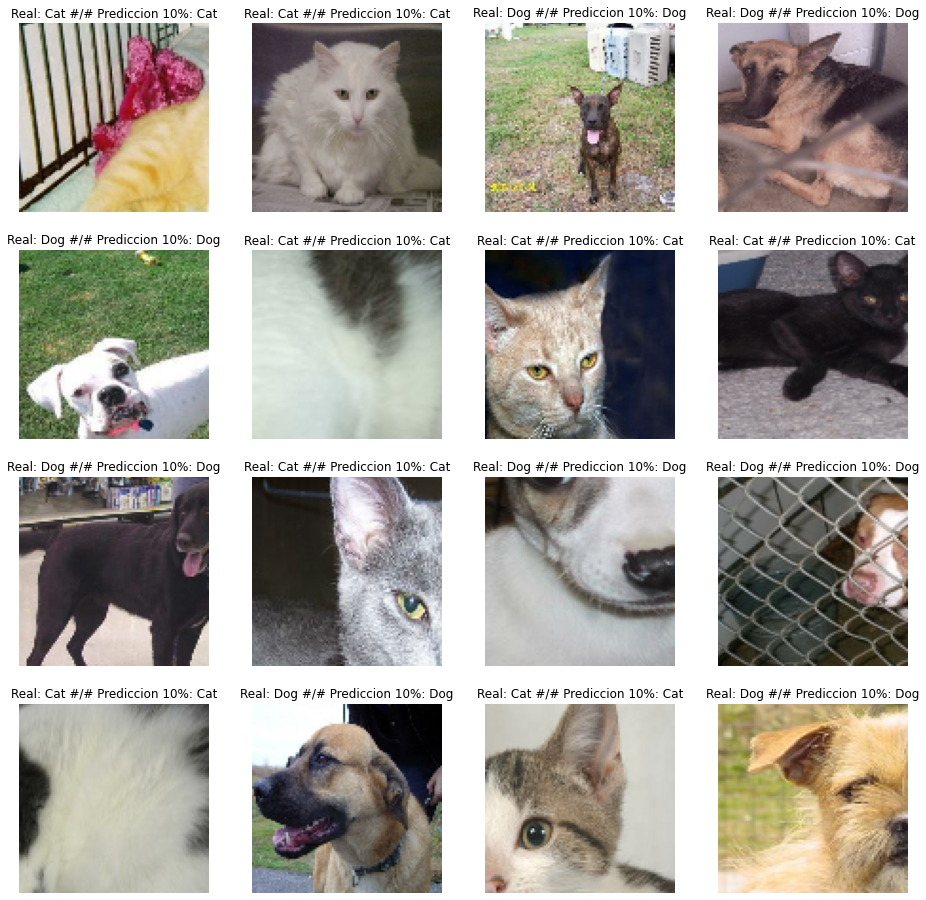

In [9]:
class_names = ['Cat', 'Dog']
plt.figure(figsize=(16, 16))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image[i])
    label = class_names[labels[i]]
    predicted = class_names[pred[i]]
    plt.title('Real: ' + label + ' #/# Prediccion 10%: ' + predicted)
    plt.axis("off")
plt.savefig('10pcttransfer_learning.jpg')

In [10]:
df = pd.DataFrame(list(zip(steps, hist_loss, hist_acc)), columns =['Steps', 'Loss', 'Accuracy'])
df.to_csv('transfer10pct50epochs.csv', index=False)